# AI Disruption Risk Report Generator


## Automated Analysis of AI Threats and Opportunities in Technology Companies


## Why It Matters

AI disruption requires identifying which companies will thrive versus those vulnerable to displacement, but evaluating AI positioning across scattered news, earnings calls, and filings is resource-intensive. Investment decisions need systematic analysis of both AI risks and strategic responses to identify winners and potential shorts.

## What It Does

The `GenerateReport` class in the bigdata-research-tools package systematically evaluates both AI disruption risks and proactive AI adoption across company watchlists using unstructured data from multiple sources. Built for portfolio managers and financial analysts, it transforms scattered AI-related information into quantifiable positioning intelligence and identifies investment opportunities based on AI readiness.

## How It Works

The Report Generator combines **semantic content retrieval**, **dual-theme analysis**, and **comparative scoring methodologies** to deliver:

- **Risk-proactivity assessment** measuring both AI disruption vulnerability and strategic AI adoption initiatives
- **Standardized scoring system** enabling cross-company comparison of AI positioning and competitive readiness
- **Investment intelligence generation** revealing underlying narratives that shape each company's AI transformation journey
- **Structured output for reporting** ranking companies by AI resilience and strategic positioning

## A Real-World Use Case

This cookbook demonstrates the complete workflow through analyzing AI disruption risks and proactive responses across a company watchlist, showing how the generator automatically quantifies AI positioning and identifies potential investment opportunities based on strategic AI readiness.


## Setup and Imports

## Async Compatibility Setup

**Run this cell first** - Required for Google Colab, Jupyter Notebooks, and VS Code with Jupyter extension:

### Why is this needed?

Interactive environments (Colab, Jupyter) already have an asyncio event loop running. When bigdata-research-tools makes async API calls (like to OpenAI), you'll get this error without nest_asyncio:

```
RuntimeError: asyncio.run() cannot be called from a running event loop
```

The `nest_asyncio.apply()` command patches this to allow nested event loops.

💡 **Tip**: If you're unsure which environment you're in, just run the cell below - it won't hurt in any environment!

In [3]:
import datetime
start = datetime.datetime.now()

In [4]:
try:
    import asyncio
    asyncio.get_running_loop()
    import nest_asyncio; nest_asyncio.apply()
    print("✅ nest_asyncio applied")
except (RuntimeError, ImportError):
    print("✅ nest_asyncio not needed or not available")

✅ nest_asyncio applied


## Environment Setup 

The following cell configures the necessary path for the analysis

In [5]:
import os
import sys


current_dir = os.getcwd()
if current_dir not in sys.path:
    sys.path.append(current_dir)
print(f"✅ Local environment setup complete")

✅ Local environment setup complete


## Import Required Libraries

Import the core libraries needed for AI disruption analysis, including the custom report generation classes and data processing tools.


In [6]:
from src.report_generator import GenerateReport
from src.summary.summary import SummarizerCompany
from src.tool import create_styled_table, plot_company_scores, plot_company_scores_log_log, generate_html_report_v4, display_report


from bigdata_research_tools.search.screener_search import search_by_companies
from bigdata_research_tools.labeler.screener_labeler import ScreenerLabeler
from bigdata_research_tools.excel import ExcelManager
from bigdata_client.models.search import DocumentType
from bigdata_client import Bigdata

import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import pandas as pd
from IPython.display import display, HTML

## Configure Output Directories

Set up the directory structure where analysis results and reports will be saved.    

In [7]:
# Define output file paths for our report
output_dir = f"{current_dir}/output"
os.makedirs(output_dir, exist_ok=True)

export_path = f"{output_dir}/ai_disruption_report.xlsx"

## Load Credentials

In [8]:

from dotenv import load_dotenv
from pathlib import Path

script_dir = Path(__file__).parent if '__file__' in globals() else Path.cwd()
load_dotenv(script_dir / '.env')

BIGDATA_USERNAME = os.getenv('BIGDATA_USERNAME')
BIGDATA_PASSWORD = os.getenv('BIGDATA_PASSWORD')
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

if not all([BIGDATA_USERNAME, BIGDATA_PASSWORD, OPENAI_API_KEY]):
    print("❌ Missing required environment variables")
    raise ValueError("Missing required environment variables. Check your .env file.")
else:
    print("✅ Credentials loaded from .env file")

✅ Credentials loaded from .env file


## Connecting to Bigdata

Create a Bigdata object with your credentials.

In [9]:
bigdata = Bigdata(BIGDATA_USERNAME, BIGDATA_PASSWORD)

## Defining the Report Parameters

### Fixed Parameters
-  **Keywords** (``keywords``): Keywords used for improving retrieval
-  **Main Theme** (``main_theme_risk``): The central concept to explore
-  **Main Theme Proactivity** (``main_theme_proactivity``): Proactive measures and strategies companies take to address the main theme risk
- **List of sentences about risk themes** (``list_sentences_risks``): Sentences used to improve the retrieval regarding the main theme
- **List of sentences about risk proactivity themes** (``list_sentences_proactivity``): Sentences used to improve the retrieval regarding the proactivity against the main theme
- **Bigdata** (``bigdata``): Bigdata connection



### Customizable Parameters
-  **Watchlist** (``my_watchlist_id``): The set of companies to analyze. This is the ID of your watchlist in https://app.bigdata.com/watchlists
-  **Model Selection** (``llm_model``): The LLM model used to label search result document chunks and generate summaries
-  **Frequency** (``freq``): The frequency of the date ranges to search over.
   Supported values:

   -  `Y`: Yearly intervals.
   -  `M`: Monthly intervals.
   -  `W`: Weekly intervals.
   -  `D`: Daily intervals. Defaults to `M`.

- **Time Period** (``start_date`` and ``end_date``): The date range over which to run the analysis

-  **Fiscal Year** (``fiscal_year``): If the document type is transcripts or
   filings, fiscal year needs to be specified

-  **Focus** (``focus``): Specify a focus within the main theme

-  **Document Limit** (``document_limit_news``, ``document_limit_filings``, ``document_limit_transcripts``): The maximum number of documents to
   return per query to Bigdata API for each category of documents

-  **Batch Size** (``batch_size``): The number of entities to include in a
   single batched query

In [10]:
# ===== Fixed Parameters =====

# Keywords for filtering content
keywords = ['AI']

# Risk Theme
main_theme_risk = 'Risks or concerns related to AI disruption'

# Proactivity Theme
main_theme_proactivity = 'Integrating GenAI into products or forming partnerships to improve GenAI offerings'

# Sentences expressing risk-related narratives
list_sentences_risks = [
    "Companies face substantial risks from AI-driven market disruptions today.",
    "AI advancements threaten traditional business models and competitive advantages.",
    "Disruption by AI can lead to loss of market share rapidly.",
    "Existing workflows may become obsolete due to AI innovations.",
    "Companies risk being outpaced by agile AI-focused competitors."
]

# Sentences expressing proactivity-related narratives
list_sentences_proactivity = [
    "Companies actively incorporate GenAI to enhance product offerings and features.",
    "Partnerships aim to improve GenAI solutions in competitive markets.",
    "Proactive firms leverage GenAI technology to boost customer engagement strategies.",
    "Organizations collaborate to advance GenAI capabilities and applications effectively.",
    "Firms invest in GenAI partnerships to innovate their service delivery."
]

In [11]:
# ===== Customizable Parameters =====

# Company Universe (from Watchlist)
my_watchlist_id = "37fe5403-9688-4313-9775-9fd9770ca6e2" #insert your watchlist
watchlist = bigdata.watchlists.get(my_watchlist_id)
companies = bigdata.knowledge_graph.get_entities(watchlist.items)
company_names = [company.name for company in companies]

# LLM Specification
llm_model = "openai::gpt-4o-mini"

# Search Frequency
search_frequency='M'

# Specify Time Range
start_date="2025-01-01"
end_date="2025-04-20"

# Fiscal Year
fiscal_year = 2025

# Document Limits
document_limit_news=10
document_limit_filings=5
document_limit_transcripts=5

# Others
batch_size=1

## Generate Report



We’re now initializing the ``GenerateReport`` class, and in the next section of the cookbook, we’ll walk through each step it takes to build the report.

But hey, if you'd rather **skip the step-by-step and jump straight to the result**, just run the cell below and then [click here](#scrollTo=-nXf6XC1tIMO) and you are good to go!🚀 Just remember follow the brief instructions to run ``generate_report()`` !



In [12]:
report_generator = GenerateReport(
        watchlist_id=my_watchlist_id,
        keywords=['AI'],
        main_theme_risk='Risks or concerns related to AI disruption',
        main_theme_proactivity='Integrating GenAI into products or forming partnerships to improve GenAI offerings',
        list_sentences_risks=list_sentences_risks,
        list_sentences_proactivity=list_sentences_proactivity,
        llm_model= llm_model,
        api_key=OPENAI_API_KEY,
        start_date=start_date,
        end_date=end_date,
        fiscal_year=fiscal_year,
        search_frequency=search_frequency,
        document_limit_news=document_limit_news,
        document_limit_filings=document_limit_filings,
        document_limit_transcripts=document_limit_transcripts,
        batch_size=batch_size,
        bigdata=bigdata
)

## Workflow step by step



### Retrieve Content

You can leverage the Bigdata API to run a search on company news, filings and transcripts.


In [13]:
# Initialize empty lists to collect dataframes
df_risk_list = []
df_proactivity_list = []

# Define the document types and limits
doc_configs = [
   (DocumentType.NEWS, document_limit_news, None),
   (DocumentType.FILINGS, document_limit_filings, fiscal_year),
   (DocumentType.TRANSCRIPTS, document_limit_transcripts, fiscal_year)
]

# Iterate through each document type configuration
for doc_type, doc_limit, year in doc_configs:
   if doc_limit > 0:
       # Search for semantic risk sentences
       df_sentences_semantic_risk_search = search_by_companies(
           companies=companies,
           keywords=keywords,
           sentences=list_sentences_risks,
           fiscal_year=year,
           start_date=start_date,
           end_date=end_date,
           scope=doc_type,
           freq=search_frequency,
           document_limit=doc_limit,
           batch_size=batch_size
       )
       df_risk_list.append(df_sentences_semantic_risk_search)

       # Search for semantic proactivity sentences
       df_sentences_semantic_proactivity_search = search_by_companies(
           companies=companies,
           keywords=keywords,
           sentences=list_sentences_proactivity,
           fiscal_year=year,
           start_date=start_date,
           end_date=end_date,
           scope=doc_type,
           freq=search_frequency,
           document_limit=doc_limit,
           batch_size=batch_size
       )
       df_proactivity_list.append(df_sentences_semantic_proactivity_search)

# Combine all risk dataframes into a single dataset
df_sentences_semantic_risk = pd.concat(df_risk_list, ignore_index=True)

# Combine all proactivity dataframes into a single dataset
df_sentences_semantic_proactivity = pd.concat(df_proactivity_list, ignore_index=True)

Querying Bigdata...: 100%|██████████| 240/240 [00:55<00:00,  4.29it/s]
Error in batch ['E44D28', '2667D0', '6602D1', '129F91', 'CEC128', '490456', '240587', 'CE679F', '4HRS13', '5Y1CUD', '1BC945', '29AE6B', 'FD891C', '498A73', '39692D', '71BCAA', '90F6EE', '335F91', '3BA7E5', '30371F', '5422B7', 'B514A1', '1F99E1', 'D98AC2', '2BC6B1', '6C78CE', '1C3BEB', '5554B2', 'F997BD', '441343', 'B4D1AB', 'I87C5U', 'E21FD5', '57E3C8', '2F382C', '6B0DC5', '7230DF', '1F26DA', 'C74288', 'CF9B6E', '85DA04', '3D27C2', 'WMG5LW', '4C9815', 'D82158', 'C70510', '228C67', 'DF61D2', 'FB0726', '699377']
requests.exceptions.HTTPError: 542 Server Error:  for url: https://api.bigdata.com/cqs/by-ids
Backend response: [VespaCodeErrorEntry(code=8, summary='Error in search reply.'), VespaCodeErrorEntry(code=12, summary='Timed out')].
Retrying...
Processing transcripts results...: 100%|██████████| 34/34 [00:00<00:00, 21287.71it/s]


In [14]:
df_sentences_semantic_risk.head(3)

,timestamp_utc,document_id,sentence_id,headline,entity_id,document_type,is_reporting_entity,entity_name,entity_sector,entity_industry,entity_country,entity_ticker,text,other_entities,entities,masked_text,other_entities_map
0,2025-01-01 17:17:25+00:00,1EE0BC9F88AB407368395D3EC5A080F2,1EE0BC9F88AB407368395D3EC5A080F2-12,Should You Buy This Artificial Intelligence (A...,365B30,news,False,C3.ai Inc.,Technology,Application Software,United States,AI,BBAI Revenue (TTM) data by YCharts All things ...,"YCharts Inc., Palantir Technologies Inc., BigB...","[{'key': 'WE7TH5', 'name': 'YCharts Inc.', 'ti...",BBAI Revenue (TTM) data by Other Company_3 All...,"[(1, Palantir Technologies Inc.), (2, BigBear...."
1,2025-01-01 17:17:25+00:00,1EE0BC9F88AB407368395D3EC5A080F2,1EE0BC9F88AB407368395D3EC5A080F2-12,Should You Buy This Artificial Intelligence (A...,F1C69A,news,False,Palantir Technologies Inc.,Technology,Data Processing & Outsourced Services,United States,PLTR,BBAI Revenue (TTM) data by YCharts All things ...,"YCharts Inc., C3.ai Inc., BigBear.ai Holdings ...","[{'key': 'WE7TH5', 'name': 'YCharts Inc.', 'ti...",BBAI Revenue (TTM) data by Other Company_3 All...,"[(4, C3.ai Inc.), (2, BigBear.ai Holdings Inc...."
2,2025-01-01 17:17:25+00:00,1EE0BC9F88AB407368395D3EC5A080F2,1EE0BC9F88AB407368395D3EC5A080F2-7,Should You Buy This Artificial Intelligence (A...,F1C69A,news,False,Palantir Technologies Inc.,Technology,Data Processing & Outsourced Services,United States,PLTR,Here's how BigBear.ai compares to its core com...,"BigBear.ai Holdings Inc., BigBear.ai Holdings ...","[{'key': '9ED735', 'name': 'BigBear.ai Holding...",Here's how Other Company_2 compares to its cor...,"[(2, BigBear.ai Holdings Inc.), (2, BigBear.ai..."


In [15]:
df_sentences_semantic_proactivity.head(3)

,timestamp_utc,document_id,sentence_id,headline,entity_id,document_type,is_reporting_entity,entity_name,entity_sector,entity_industry,entity_country,entity_ticker,text,other_entities,entities,masked_text,other_entities_map
0,2025-01-01 09:15:43+00:00,17C9BCDB3DECE17E11EAEA8B3E91F7C3,17C9BCDB3DECE17E11EAEA8B3E91F7C3-5,"Nvidia, Google and the Hardware Revolution Beh...",F1C69A,news,False,Palantir Technologies Inc.,Technology,Data Processing & Outsourced Services,United States,PLTR,AI Moves From Lab to Market The AI wave reache...,Anduril Industries Inc.,"[{'key': 'F1C69A', 'name': 'Palantir Technolog...",AI Moves From Lab to Market The AI wave reache...,"[(1, Anduril Industries Inc.)]"
1,2025-01-02 14:10:01+00:00,8D3ADE495C8B8C7DC5A85EE8CD19B427,8D3ADE495C8B8C7DC5A85EE8CD19B427-1,SoundHound AI and Lucid Motors Bring In-Vehicl...,D957DE,news,False,SoundHound AI Inc.,Technology,Software,United States,SOUN,"SoundHound AI, Inc. (NASDAQ: SOUN), a global l...","Lucid Motors Inc., Lucid Motors Inc., Lucid Mo...","[{'key': '516EF4', 'name': 'Lucid Motors Inc.'...","Target Company, a global leader in voice artif...","[(2, Lucid Motors Inc.), (2, Lucid Motors Inc...."
2,2025-01-02 14:27:52+00:00,BED9F5F034165982A29D0D22A6FF39B1,BED9F5F034165982A29D0D22A6FF39B1-6,'Hey Lucid': SoundHound AI Powers Next-Gen Voi...,D957DE,news,False,SoundHound AI Inc.,Technology,Software,United States,SOUN,"""In combination with Lucid's frequent over-the...","Lucid Group Inc., Lucid Group Inc., Lucid Grou...","[{'key': 'BD3834', 'name': 'Lucid Group Inc.',...","""In combination with Other Company_3's frequen...","[(3, Lucid Group Inc.), (3, Lucid Group Inc.),..."


### Label the Results

Use an LLM to analyze each document chunk and determine its relevance to the main theme. Any document chunks which aren't explicitly linked to AI Disruption Risk will be filtered out.


In [16]:
labeler = ScreenerLabeler(llm_model=llm_model)

df_risk_labels = labeler.get_labels(
                main_theme=main_theme_risk,
                labels=['risk'],
                texts=df_sentences_semantic_risk["masked_text"].tolist()
            )

# Merge the datasets
df_risk_labeled = pd.merge(df_sentences_semantic_risk, df_risk_labels, left_index=True, right_index=True)

df_proactivity_labels = labeler.get_labels(
                main_theme=main_theme_proactivity,
                labels=['proactivity'],
                texts=df_sentences_semantic_proactivity["masked_text"].tolist()
            )

# Merge the datasets
df_proactivity_labeled = pd.merge(df_sentences_semantic_proactivity, df_proactivity_labels, left_index=True, right_index=True)


# Process the results
df_risk_labeled_relevant = df_risk_labeled.loc[~df_risk_labeled.label.isin(['', 'unassigned', 'unclear'])].copy()
df_proactivity_labeled_relevant = df_proactivity_labeled.loc[~df_proactivity_labeled.label.isin(['', 'unassigned', 'unclear'])].copy()

Querying OpenAI...: 100%|██████████| 2328/2328 [03:00<00:00, 12.88it/s]


### Document Distribution Visualization

You can visualize the tables showing the count of different document types for each company in the given universe. This helps you understand the distribution and availability of information across different sources for each entity.


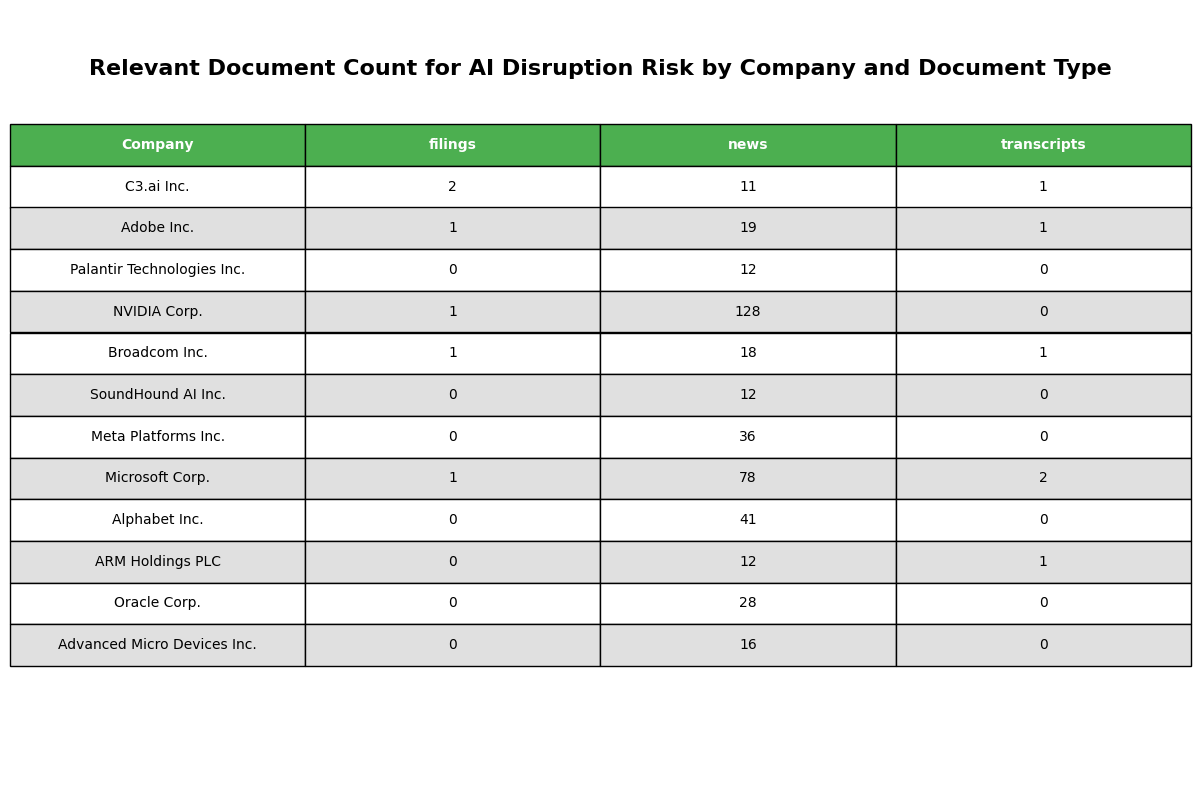

In [17]:
create_styled_table(df_risk_labeled_relevant, title='Relevant Document Count for AI Disruption Risk by Company and Document Type', companies_list = company_names)

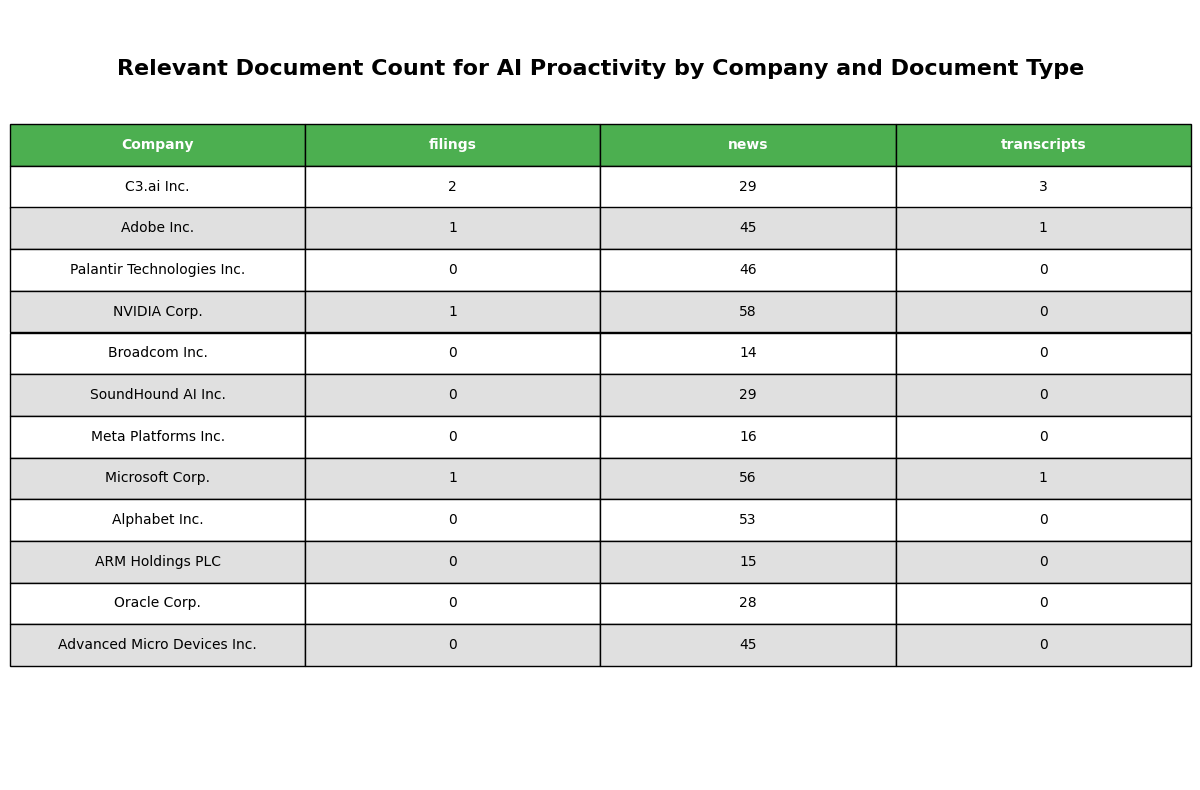

In [18]:
create_styled_table(df_proactivity_labeled_relevant, title='Relevant Document Count for AI Proactivity by Company and Document Type', companies_list = company_names)

### Summarizer

The following code is used to create a summary for each company using the information from the retrieved documents.



In [19]:
summarizer_company = SummarizerCompany(
    model=llm_model.split('::')[1],
    api_key=OPENAI_API_KEY,
    logger= GenerateReport.logger,
    verbose=True
)

In [20]:
df_risk_by_company = asyncio.run(
            summarizer_company.process_by_company(
                df_labeled=df_risk_labeled_relevant,
                list_entities=companies,
                theme=main_theme_risk,
                focus='risk'
            ))

df_proactivity_by_company = asyncio.run(
            summarizer_company.process_by_company(
                df_labeled=df_proactivity_labeled_relevant,
                list_entities=companies,
                theme=main_theme_proactivity,
                focus=''
            )
        )

2025-07-14 14:42:30,362 - INFO - Preparing topics from the labeled DataFrame
2025-07-14 14:42:30,364 - INFO - Starting processing for 12 tasks...
2025-07-14 14:42:40,404 - INFO - Preparing topics from the labeled DataFrame
2025-07-14 14:42:40,408 - INFO - Starting processing for 12 tasks...


### Getting the Scores



Processing the datasets and computing the **AI Disruption Risk Score** and **AI Proactivity Score**.



In [21]:
dfr = df_risk_by_company[['entity_id', 'entity_name', 'topic_summary', 'n_documents']].copy()
dfr = dfr.rename(columns={'topic_summary': 'risk_summary', 'n_documents': 'n_documents_risk'})
dfp = df_proactivity_by_company[['entity_id', 'entity_name', 'topic_summary', 'n_documents']].copy()
dfp = dfp.rename(columns={'topic_summary': 'proactivity_summary', 'n_documents': 'n_documents_proactivity'})
df_by_company = dfr.merge(dfp, on=['entity_id', 'entity_name'], how='outer')

df_by_company['n_documents_risk'] = df_by_company['n_documents_risk'].fillna(0)
df_by_company['n_documents_proactivity'] = df_by_company['n_documents_proactivity'].fillna(0)
df_by_company['ai_disruption_risk_score'] = df_by_company['n_documents_risk']/df_by_company['n_documents_risk'].mean()
df_by_company['ai_proactivity_score'] = df_by_company['n_documents_proactivity']/df_by_company['n_documents_proactivity'].mean()
df_by_company['ai_proactivity_minus_disruption_risk_score'] = df_by_company['ai_proactivity_score'] - df_by_company['ai_disruption_risk_score']

### Final Dataset

The final dataset for the report is generated by processing and merging the risk and proactivity datasets.

In [22]:
df_quotes_risk = GenerateReport.aggregate_verbatim(df_risk_labeled_relevant, 'risk')
df_by_company = pd.merge(df_by_company, df_quotes_risk, how='left', on='entity_name')
df_quotes_proactivity = GenerateReport.aggregate_verbatim(df_proactivity_labeled_relevant, 'proactivity')
df_report = pd.merge(df_by_company, df_quotes_proactivity, how='left', on='entity_name')

In [23]:
df_report.head()

,entity_id,entity_name,risk_summary,n_documents_risk,proactivity_summary,n_documents_proactivity,ai_disruption_risk_score,ai_proactivity_score,ai_proactivity_minus_disruption_risk_score,document_ids_risk,quotes_risk,document_ids_proactivity,quotes_proactivity
0,09DE1F,Broadcom Inc.,Broadcom Inc. faces significant risks related ...,20,Broadcom Inc. is strategically enhancing its p...,14,0.567376,0.378378,-0.188998,04455531162DD3652AD9B32A76189C53 \n\n 04455531...,--- Quote Start ---\n\n Headline: Broadcom's S...,BD832690FA171DF227E4A0F662158C54 \n\n 855E90E5...,--- Quote Start ---\n\n Headline: NVIDIA Faces...
1,12E454,Meta Platforms Inc.,Meta Platforms Inc. faces significant risks re...,36,Meta Platforms Inc. has made significant strid...,16,1.021277,0.432432,-0.588844,D94DAB37058831C01598A174B4D30B70 \n\n 5FFCC23F...,--- Quote Start ---\n\n Headline: The fight fo...,89A4AFE40DEDA67E41B7246FF2558EF6 \n\n 89A4AFE4...,--- Quote Start ---\n\n Headline: Meta Joins D...
2,228D42,Microsoft Corp.,Microsoft Corp. faces significant risks relate...,81,Microsoft Corp. is actively integrating Genera...,58,2.297872,1.567568,-0.730305,D94DAB37058831C01598A174B4D30B70 \n\n 5FFCC23F...,--- Quote Start ---\n\n Headline: The fight fo...,49B9C32D0CAA052A05F1BA79CEBB2111 \n\n 90BAF917...,--- Quote Start ---\n\n Headline: DEWA Unveils...
3,365B30,C3.ai Inc.,C3.ai Inc. faces significant risks related to ...,14,C3.ai Inc. has significantly expanded its part...,34,0.397163,0.918919,0.521756,B6A07741D845537A8AA601BF52D6C534 \n\n 0965E23E...,--- Quote Start ---\n\n Headline: C3 AI and Mc...,70DAE658564E11E8917C59087E5ED6CD \n\n CCE8EF98...,--- Quote Start ---\n\n Headline: C3.ai CEO Th...
4,4A6F00,Alphabet Inc.,Alphabet Inc. faces significant risks related ...,41,Alphabet Inc. is actively enhancing its Genera...,53,1.163121,1.432432,0.269312,D94DAB37058831C01598A174B4D30B70 \n\n D94DAB37...,--- Quote Start ---\n\n Headline: The fight fo...,A5FA90201F429133D2CD75577519FD9D \n\n 34B21F63...,--- Quote Start ---\n\n Headline: EPAM Expands...


## Direct method



Once the class `GenerateReport` is initialized you can just run the method `generate_report()` to get the final output and then you can run the functions to visualize the results and to generate the report.

For practical reasons you can also choose to import and/or export the intermediate outputs to/from a specific directory:



*   **import_from_path**: File path from where the intermediate outputs will be loaded
*   **export_to_path**: File path where the intermediate outputs will be saved




To run the direct method uncomment the variable `DIRECT_METHOD`

To export the intermediate results / final outputs uncomment the variable `EXPORT_RESULTS`

In [24]:
# Uncomment the flag DIRECT_METHOD to run the workflow
#DIRECT_METHOD_FLAG = True
#EXPORT_RESULTS_FLAG = True

if 'DIRECT_METHOD_FLAG' in globals() and DIRECT_METHOD_FLAG:
  if 'EXPORT_RESULTS_FLAG' in globals() and EXPORT_RESULTS_FLAG:
    report = report_generator.generate_report(import_from_path=output_dir, export_to_path=output_dir)
  else:
    report = report_generator.generate_report()
  df_report = report.report_by_company
  df_report.head(5)

## Results Visualization


This is to visualize the values for each of the companies

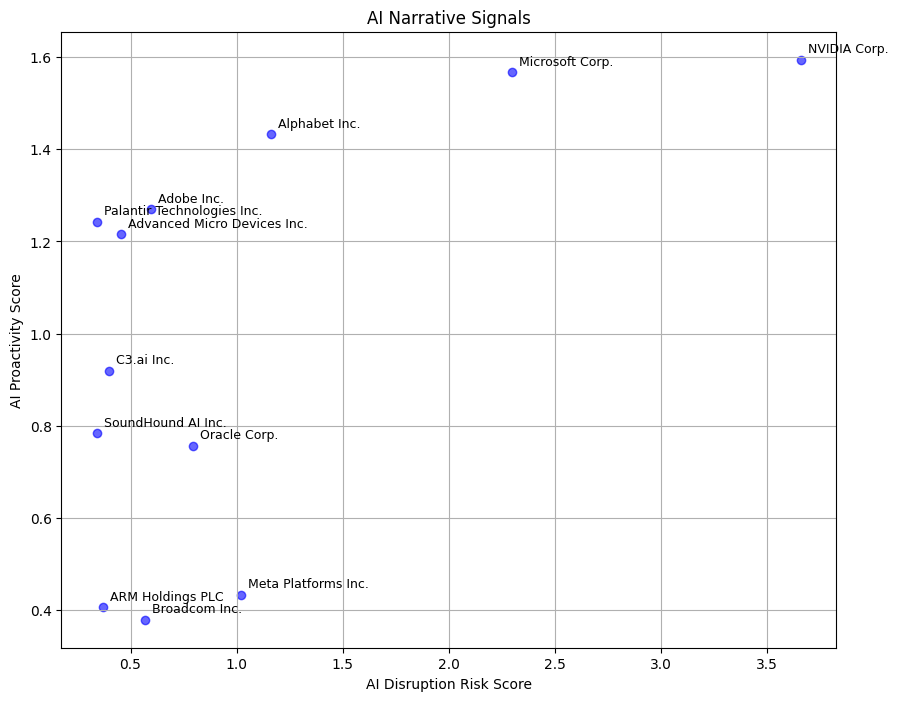

In [25]:
plot_company_scores(df_report, 'ai_disruption_risk_score', 'ai_proactivity_score', 'AI Narrative Signals')

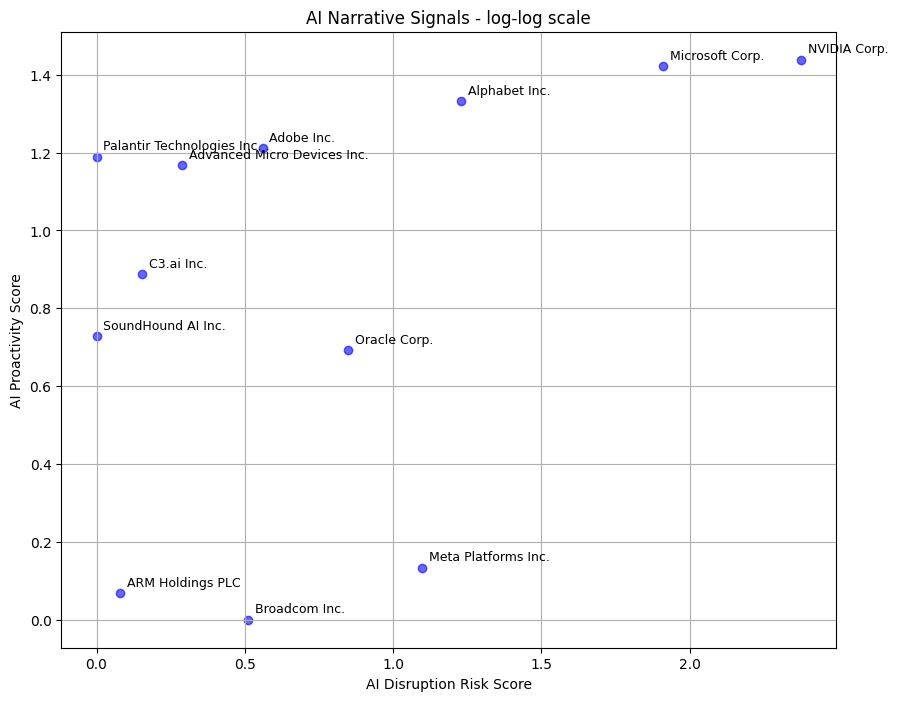

In [26]:
plot_company_scores_log_log(df_report, 'ai_disruption_risk_score', 'ai_proactivity_score', 'AI Narrative Signals')

## Generate Final Report

The final report will be saved as a html file in the folder `export_path`

In [27]:
display_report(df_report=df_report, score='ai_proactivity_minus_disruption_risk_score', top='top', nb_entities=5, export_to_path=output_dir+'/report_ai_disruption_top_5.html')

## Export the Results

Export the data as Excel files for further analysis or to share with the team.

In [ ]:
try:
    # Create the Excel manager
    excel_manager = ExcelManager()

    # Define the dataframes and their sheet configurations
    df_args = [
        (df_report, "Report AI Disruption Risk", (2, 3))
    ]

    # Save the workbook
    excel_manager.save_workbook(df_args, export_path)

except Exception as e:
    print(f"Warning while exporting to excel: {e}")

In [29]:
print("Runtime:", datetime.now() - start)

Runtime: 0:14:38.602982
